# Experiment 0

## To Do

* Function that appends objective values to boards
* Fuction that recreates game in real time as movie
* Function that counts number of pieces on the board

## Setup

### Import Packages

In [22]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import scipy.optimize as opt
import scipy.stats as sts
import seaborn as sns
%cd ~/Google Drive/MNK/Experiments/0 Two Player Free Play/

/Users/gianni/Google Drive/MNK/Experiments/0 Two Player Free Play


/Users/gianni/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Set Directories

In [2]:
data_source = 'Data & Analysis/Clean/'
figure_out = 'Data & Analysis/Figures/weiji_talk/'

### Helper Functions

In [3]:
def detect_error(row):
    is_error = np.nan
    if row.color == 0:  
        is_error = 1 if row.gtv < row.posqual else 0
    else:  
        is_error = 1 if row.gtv > row.posqual else 0  
    return is_error

def array_from_string_rep(stringrep):
    return np.array(list(stringrep)).astype(int)

def count_pieces(stringrep):
    return array_from_string_rep(stringrep).sum()

### Load Data

#### Experimental Data

In [4]:
data = pd.read_csv(data_source + 'all_data_with_initials0.csv')
data = data.loc[:, data.columns.values[1:]]

data.loc[:, 'num_pieces'] = data.loc[:, 'bp'].map(count_pieces) + data.loc[:, 'wp'].map(count_pieces)

#### Parameters and Fits

In [5]:
logliks = pd.read_csv(data_source + 'loglik_all.csv')
params_hk = pd.read_csv(data_source + 'params_HK.txt', sep='\t', names=range(15))
bfs_names = ['K0', 'Gamma', 'Lapse Rate', 'Delta', 
             'Vertical Scale', 'Diagonal Scale', 'Opponent Scale', 
             'Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 
             'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7']
params_bfs = pd.read_csv(data_source + 'params_bfs.txt', sep='\t', names=bfs_names)
logliks = logliks.loc[:37, :]
logliks.loc[:, 'ID'] = logliks.loc[:, 'Initials'].map(dict(zip(data.inits.unique(), np.arange(len(data.inits.unique())))))
meltnames = ['Depth-first', 'Best-first', 'Optrand', 'Notree', 'Myopic', 'Chance']
tidy_ll = pd.melt(logliks, id_vars=['ID'], value_vars=meltnames, 
                  var_name='Model', value_name='ll')

#### Objective values

In [6]:
objlists = ['objective_values_gen2.txt', 'objective_values_hvh.txt', 'objective_values_eye.txt']
obj = pd.concat([pd.read_csv(data_source + o, sep='\t', 
                            names=['bp', 'wp'] + list(range(36))) 
                for o in objlists]).reset_index(drop=True)

In [7]:
data.loc[:, 'gtv'] = np.nan
data.loc[:, 'posqual'] = np.nan
data.loc[:, 'error'] = np.nan

for i in data.index.values:
    
    r = int(data.loc[i, 'response'])
    bp = data.loc[i, 'bp']
    wp = data.loc[i, 'wp']
    c = data.loc[i, 'color']
    
    match = obj.loc[(obj.bp == bp) & (obj.wp == wp), :]
    
    if len(match) >= 1:
        gtv = match.loc[:, 35-r].values[0]
        pqual = np.nanmax(match.loc[:, list(range(35))].values[0])
        
        data.loc[i, 'gtv'] = gtv
        data.loc[i, 'posqual'] = pqual if c == 0 else -pqual
        
    data.loc[i, 'error'] = detect_error(data.loc[i, :])

data.loc[0, 'gtv'] = data.loc[0, 'gtv'].astype(float)

/Users/gianni/anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:319: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


### Plotting

In [8]:
sns.set_palette('deep')
sns.set_style('white')
sns.set_context('poster')
B, G, R, P = sns.color_palette('deep', 4)
%matplotlib inline

## Boilerplate Stuff

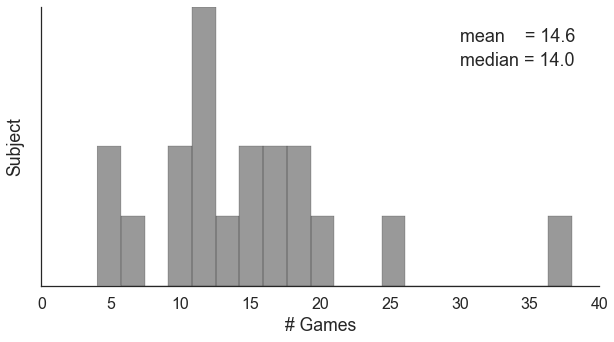

In [9]:
numgames = np.array([data.loc[data.subject==s, 'gi'].max()
        for s in data.subject.unique()
    ])
f, axes = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
sns.distplot(numgames, ax=axes[0, 0], color='black', kde=False, norm_hist=False, bins=20)
axes[0, 0].set_xlabel('# Games')
axes[0, 0].set_yticklabels([])
axes[0, 0].set_ylabel('Subject')
axes[0, 0].text(x=30, y=7, s='mean    = ' + str(numgames.mean())[:4], fontsize=18)
axes[0, 0].text(x=30, y=6.3, s='median = ' + str(np.median(numgames))[:4], fontsize=18)
sns.despine()
f.savefig(figure_out + 'games_per_subject.png', format='png')

### Moves per game

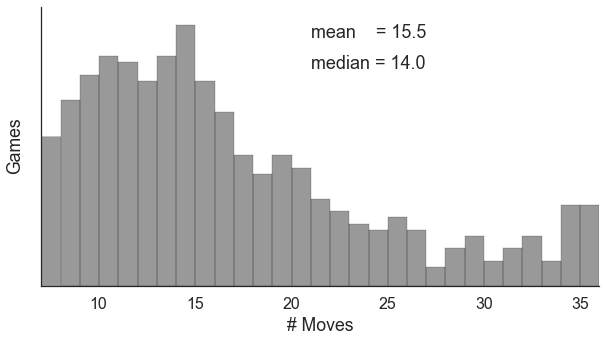

In [10]:
nummoves = np.array([data.loc[(data.subject==s)&(data.gi==g), 'mi'].max() 
            for s in data.subject.unique() 
            for g in data.loc[data.subject == s, 'gi'].unique()])

f, axes = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
sns.distplot(nummoves[np.where(nummoves >= 7)[0]], 
             ax=axes[0, 0], color='black', kde=False, norm_hist=False,
             bins=np.linspace(7, 36, 30))
axes[0, 0].set_xlabel('# Moves')
axes[0, 0].set_yticklabels([])
axes[0, 0].set_ylabel('Games')
axes[0, 0].text(x=21, y=40, s='mean    = ' + str(nummoves.mean())[:4], fontsize=18)
axes[0, 0].text(x=21, y=35, s='median = ' + str(np.median(nummoves))[:4], fontsize=18)
axes[0, 0].set_xlim([7, 36])
sns.despine()
f.savefig(figure_out + 'moves_per_game.png', format='png')

## Model Statistics

### Loglikelihood Comparisons

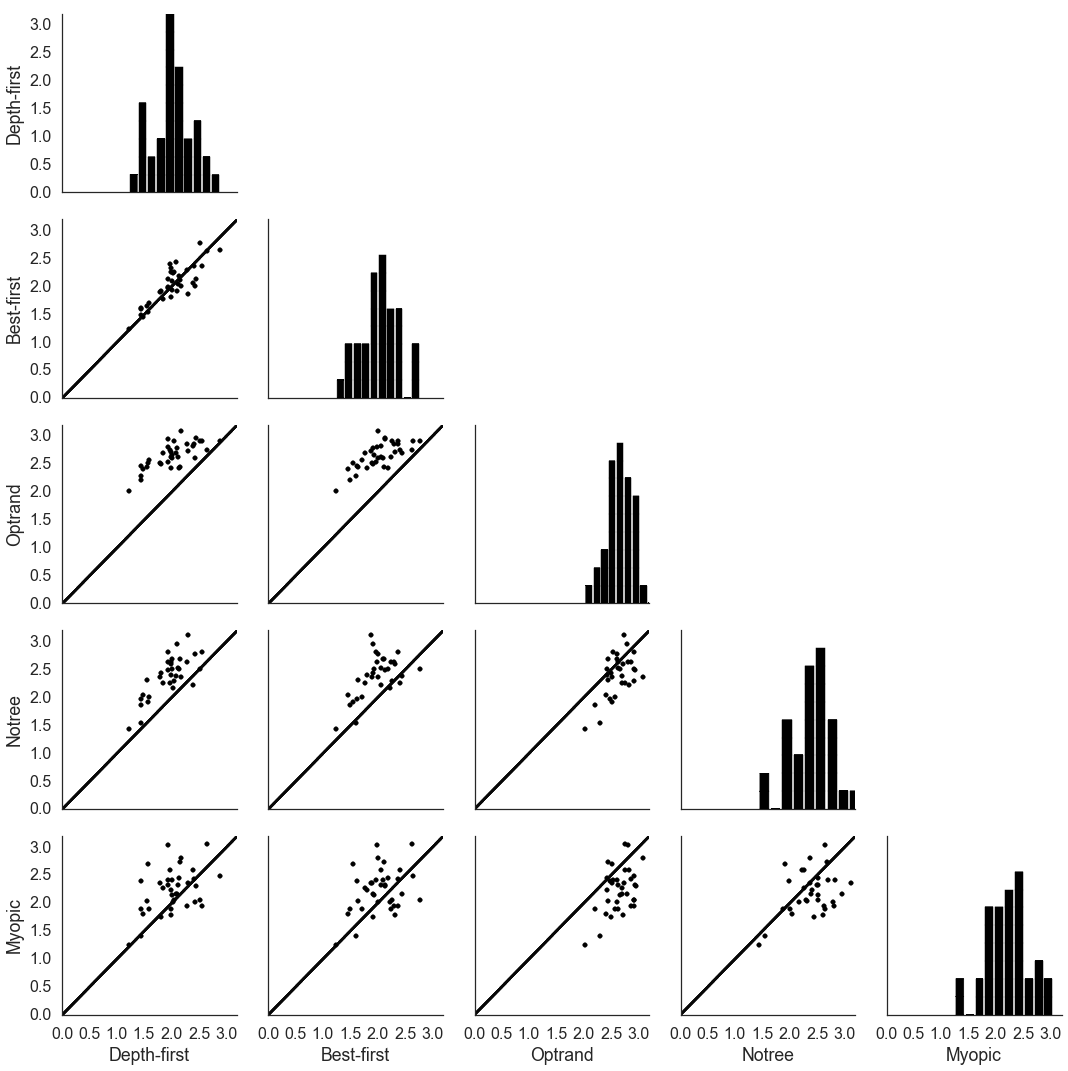

In [33]:
g = sns.pairplot(logliks, vars=['Depth-first', 'Best-first', 'Optrand', 'Notree', 'Myopic'],
                palette=sns.color_palette(['#000000']), hue='ID')
line = {'xdata':[0, 3.2], 'ydata':[0, 3.2]}
g.map_offdiag(plt.plot, color='black', alpha=.1, **line)
g.set(xlim=[0, 3.2], ylim=[0, 3.2])

tops = [1, 2, 3, 4, 7, 8, 9, 13, 14, 19]
bottoms = [5, 10, 11, 15, 16, 17, 20, 21, 22, 23, 24]
middles = [0, 6, 12, 18, 24]

for i in tops:
    g.fig.axes[i].set_visible(False)

g._legend.set_visible(False);
g.fig.savefig(figure_out + 'model_crossperformance_with_hists.png', format='png')


### Parameter Histograms

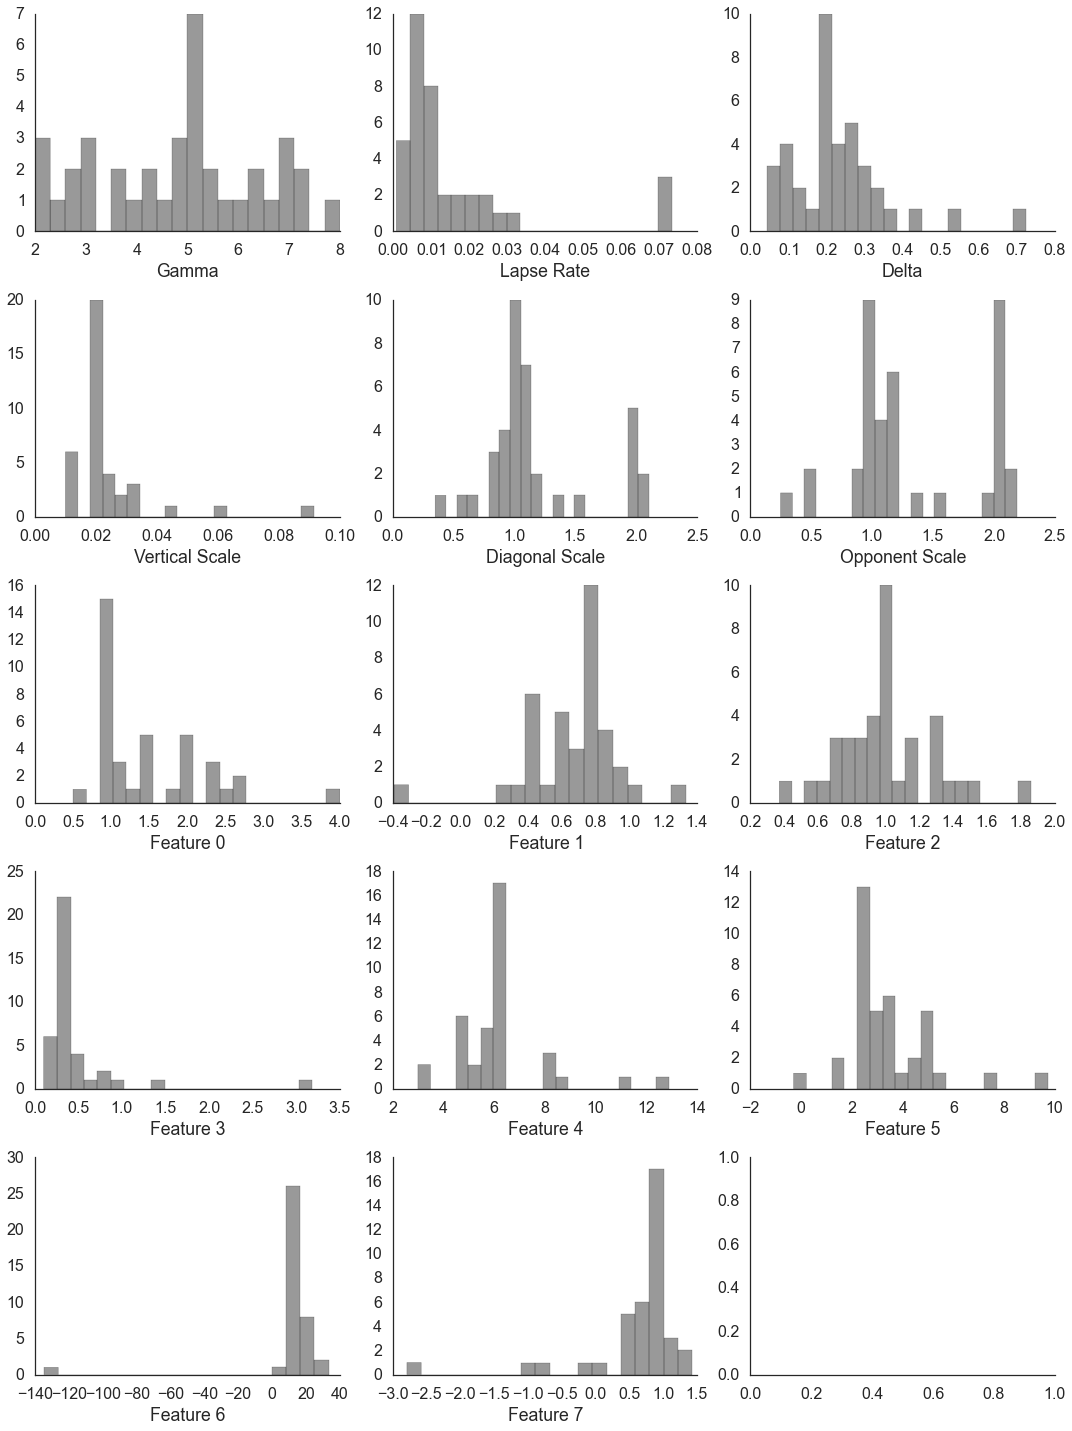

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20), squeeze=False)

for i in range(15)[1:]:
    axi = i - 1
    curax = axes[axi // 3, axi%3]
    vals = params_bfs.loc[:, bfs_names[i]]
    sns.distplot(vals, color='black', ax=curax, 
                 bins=np.linspace(vals.min(), vals.max(), 21), kde=False)
    curax.set_xlabel(bfs_names[i])
sns.despine()
fig.tight_layout()
fig.savefig(figure_out + "BFS_param_hists.png", format='png')

## Behavioral Statistics

### Response Times

#### Histograms by subject

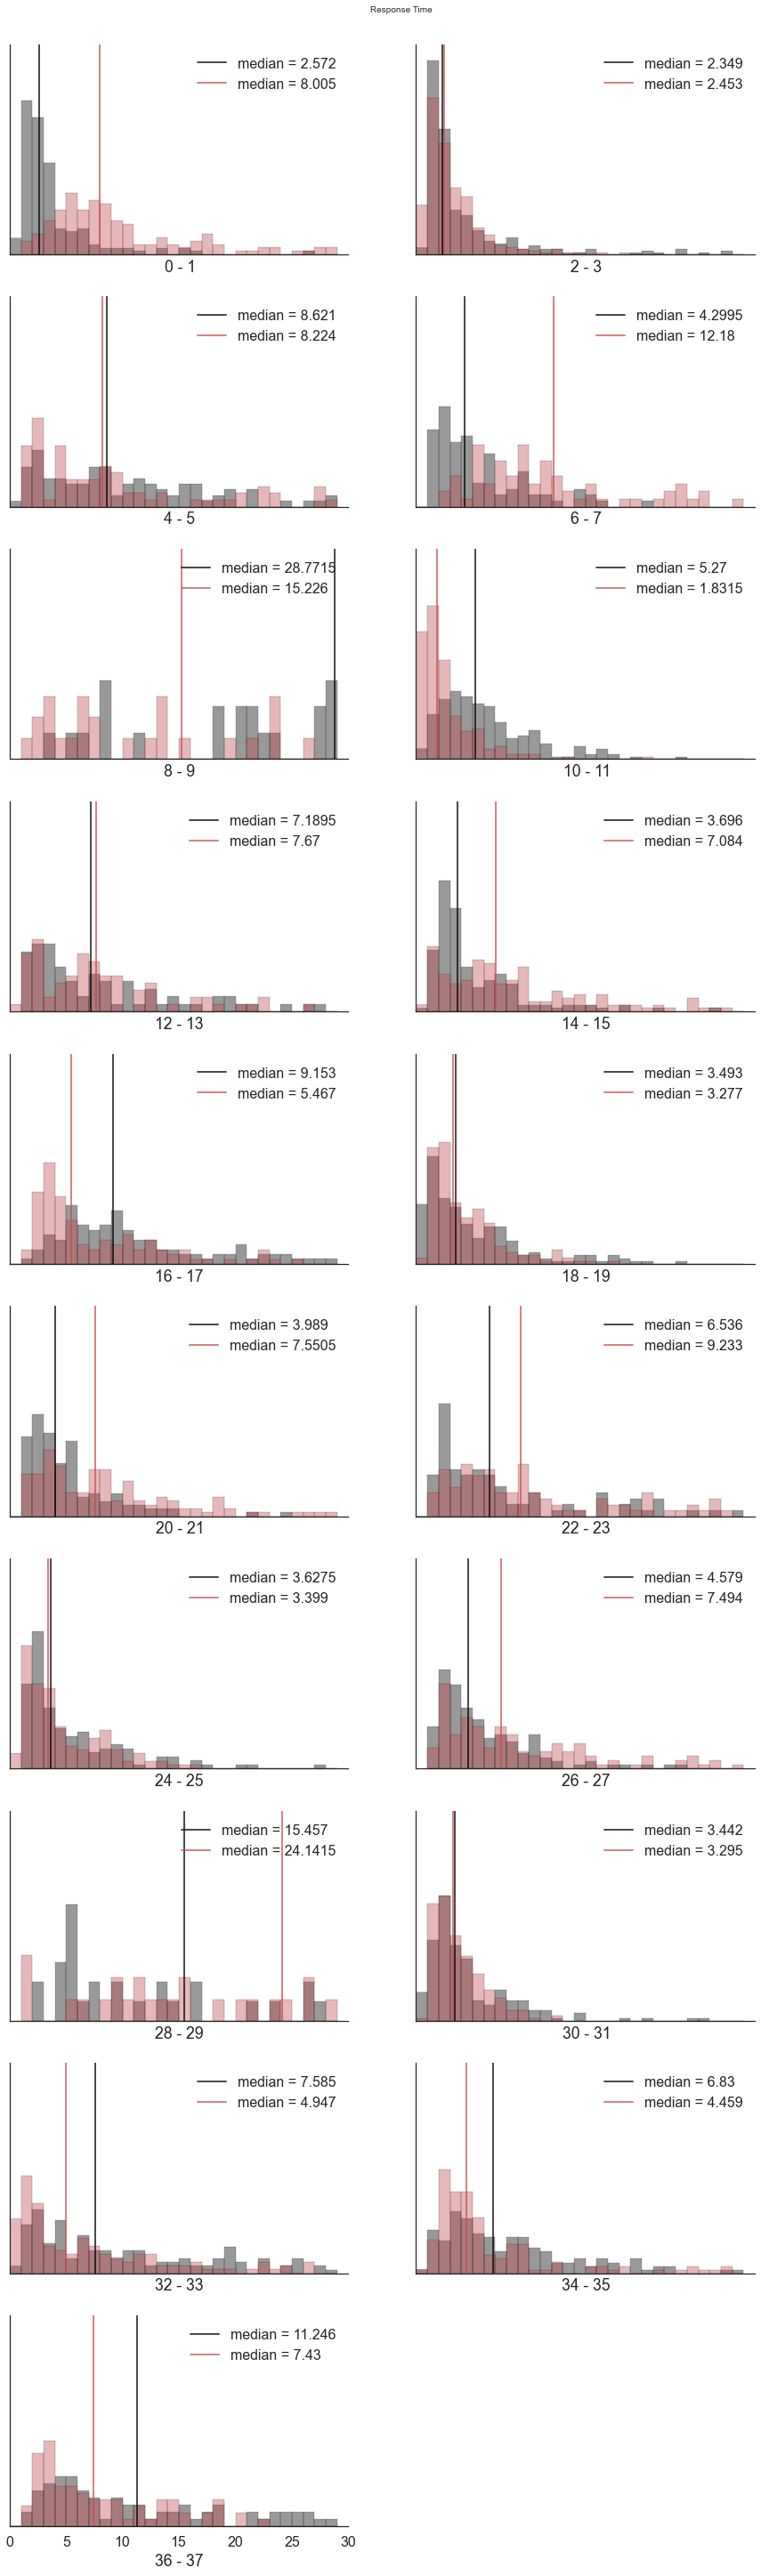

In [59]:
def time_hist(data, ax, color='black'):
    rts = data.loc[:, 'rt']
    nrts = rts/rts.sum()
    rt_median = np.median(rts)
    sns.distplot(rts, ax=ax, bins=range(30), color=color, norm_hist=True, kde=False)
#     sns.kdeplot(rts, ax=ax, color=color, shade=True, legend=False, **{'label':''})
    ax.plot([rt_median, rt_median], [0, 1], color=color, 
            linewidth=2, alpha=.7, label="median = " + str(rt_median))
    ax.set_xlim([0, 30])
    ax.set_ylim([0, .4])
    ax.legend()
    return ax
    
f, axes = plt.subplots(10, 2, figsize=(15,50), sharex=True, sharey=True, squeeze=False)

for s in range(19):
    curax = axes[s//2, s%2]
    _s = 2*s
    s1 = data.loc[data.subject==_s, :]
    s2 = data.loc[data.subject==(_s+1), :]
    time_hist(s1, curax)
    time_hist(s2, curax, color=R)
    curax.set_xlabel(str(_s) + ' - ' + str(_s+1))
    curax.set_yticklabels([])

axes[9,1].set_visible(False)
sns.despine()   
f.text(x=.5, y=.91, s='Response Time')
f.savefig(figure_out + "response_hists.png", format='png');

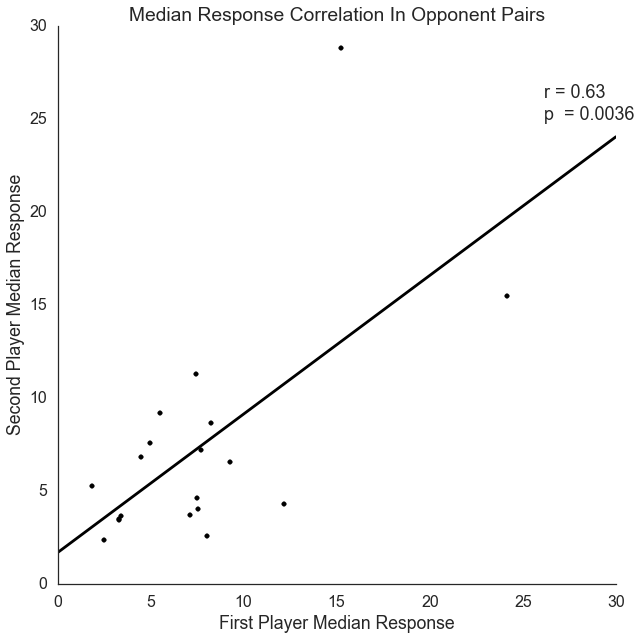

In [58]:
f, axes = plt.subplots(1, 1, figsize=(10,10), squeeze=False)

x = np.array([np.median(data.loc[data.subject == i, 'rt']) 
              for i in data.loc[data.subject%2 == 1, 'subject'].unique()])
y = np.array([np.median(data.loc[data.subject == i, 'rt']) 
              for i in data.loc[data.subject%2 == 0, 'subject'].unique()])

m, b, r, p, err = sts.linregress(x,y)
xl = np.linspace(0, 30, 11)
yl = m*xl + b

ax = axes[0, 0]
ax.scatter(x, y, c='black')
ax.set_xlim([0,30])
ax.set_xlabel("First Player Median Response")
ax.set_ylim([0, 30])
ax.set_ylabel("Second Player Median Response")
ax.set_title("Median Response Correlation In Opponent Pairs")
f.text(x=.8, y=.8, s="r = " + str(r)[:4], size=18)
f.text(x=.8, y=.77, s="p  = " + str(p)[:6], size=18)
ax.plot(xl, yl, color='black')
sns.despine()
f.savefig(figure_out + "response_correlation.png", format="png")

## Objective Errors

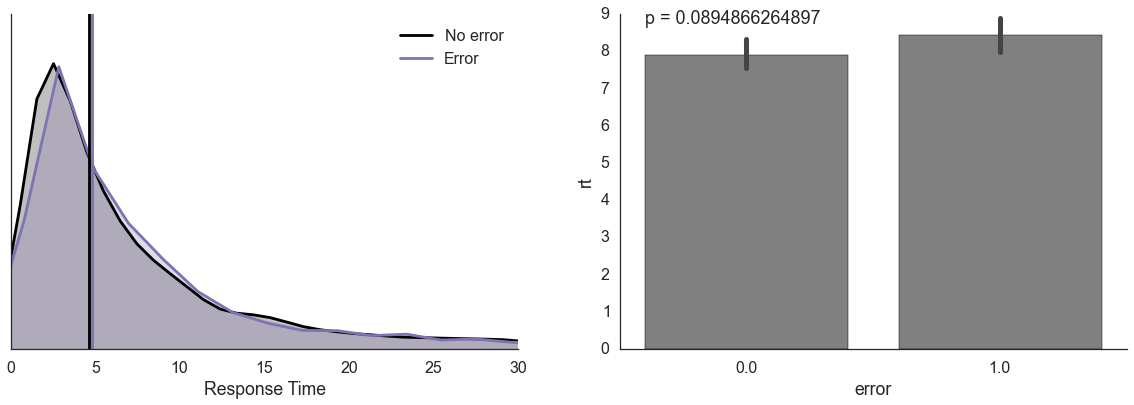

In [24]:
f, axes = plt.subplots(1, 2, figsize=(20,6), squeeze=False)

sns.kdeplot(data.loc[data.error==0, 'rt'], color='black', ax=axes[0, 0], shade=True, **{'label':'No error'})
sns.kdeplot(data.loc[data.error==1, 'rt'], color=P, ax=axes[0, 0], shade=True, **{'label':'Error'})
axes[0,0].plot([np.median(data.loc[data.error==0, 'rt']), np.median(data.loc[data.error==0, 'rt'])],
              [0, 100], color='black')
axes[0,0].plot([np.median(data.loc[data.error==1, 'rt']), np.median(data.loc[data.error==1, 'rt'])],
              [0, 100], color=P)
axes[0,0].set_xlim([0, 30])
axes[0,0].set_xlabel('Response Time')
axes[0,0].set_ylim([0, .15])
axes[0,0].set_yticklabels([])


sns.barplot('error', 'rt', data=data, ax=axes[0,1], color='grey')
t, p = sts.ttest_ind(data.loc[data.error==0, 'rt'].values, data.loc[data.error==1, 'rt'].values)
axes[0,1].text(x=-.4, y=8.75, s="p = " + str(p), size=18)
axes[0,1].set_xlabel('Error')

sns.despine()
f.savefig(figure_out + 'group_diff_error.png', format='png')


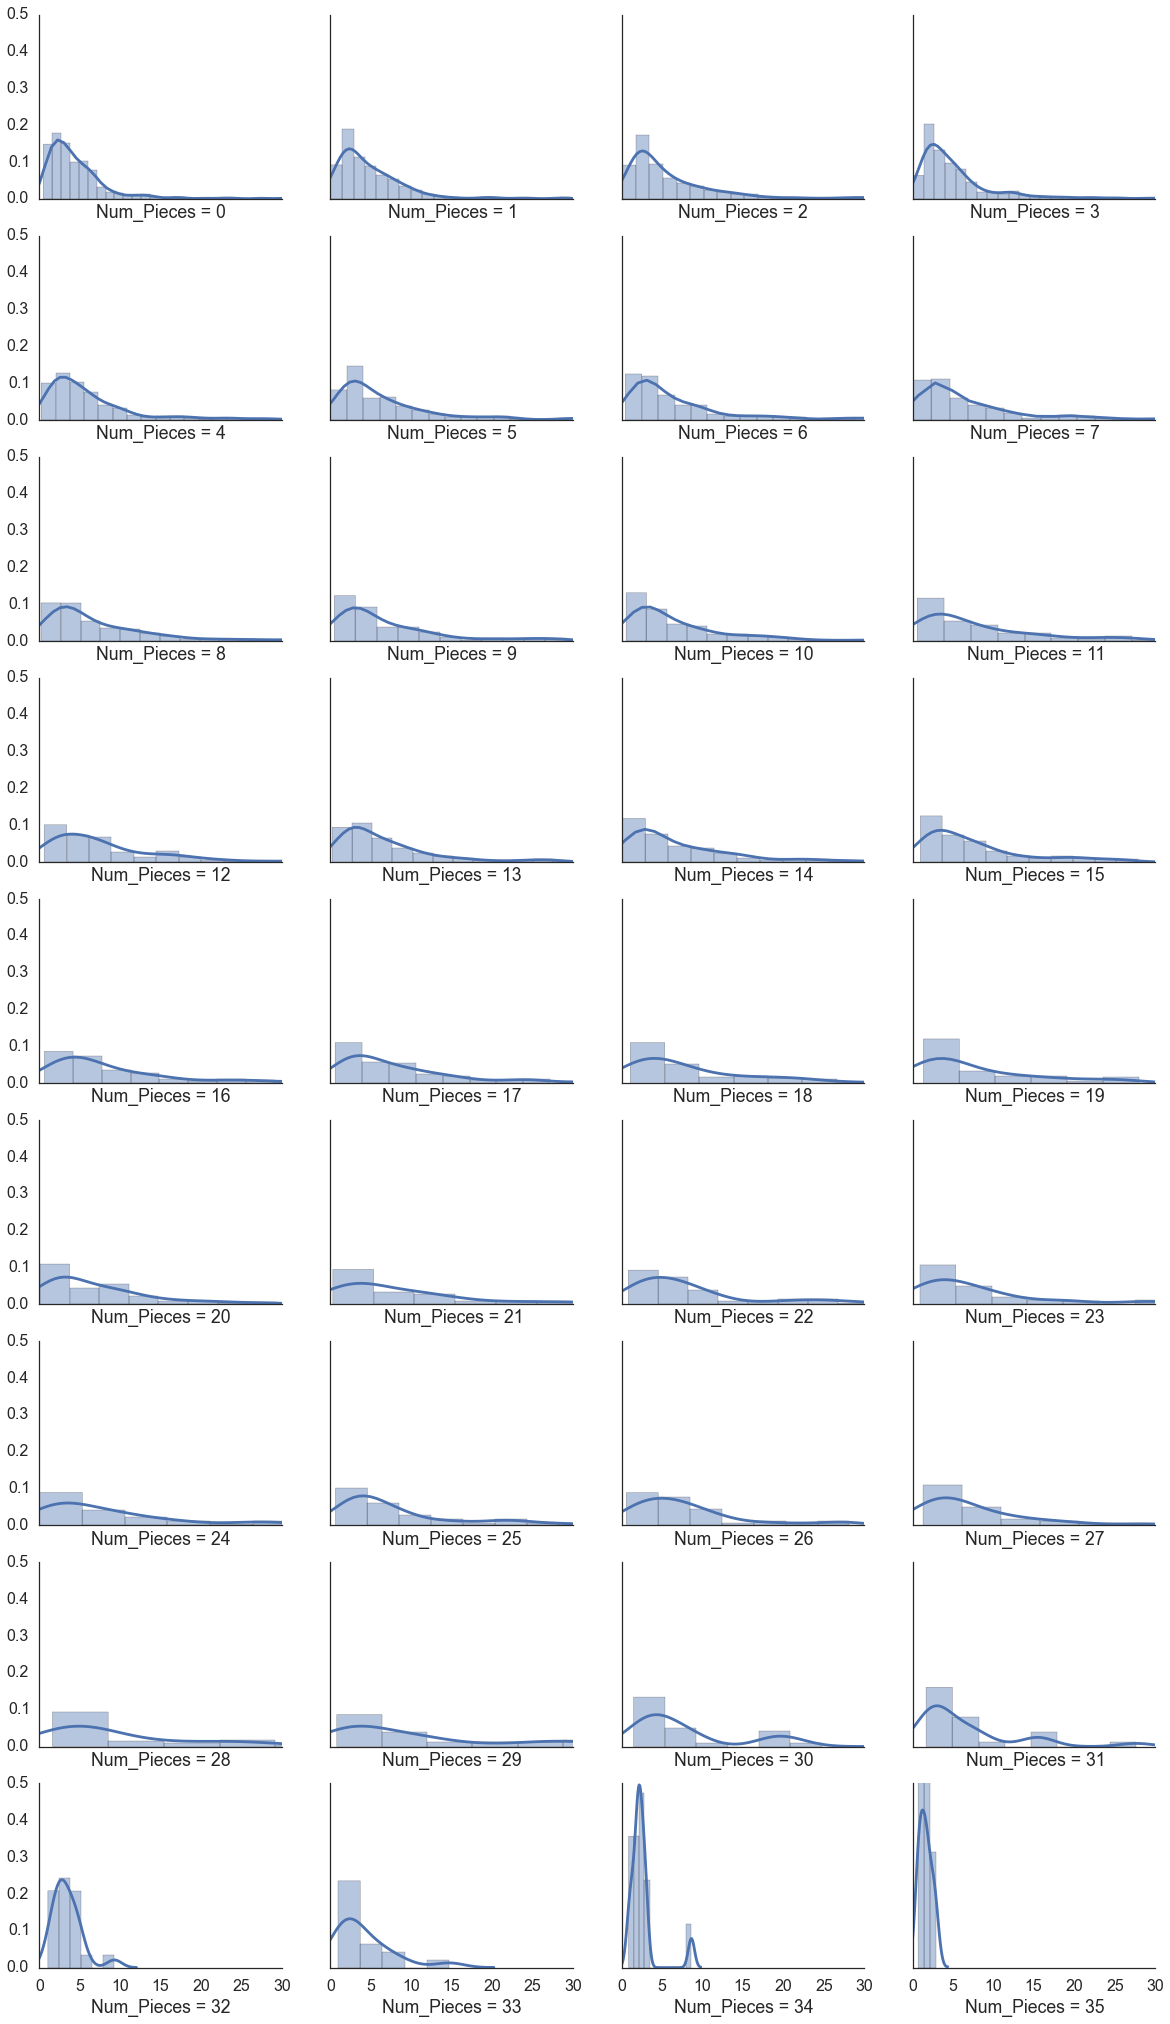

In [41]:
f, axes = plt.subplots(nrows=9, ncols=4, figsize=(20, 35), squeeze=False, sharex=True, sharey=True)

for i in range(36):
    crax = axes[i//4, i%4]
    sns.distplot(data.loc[data.mi==i, 'rt'], ax=crax)
    crax.set_xlim([0,30])
    crax.set_ylim([0, .5])
    crax.set_xlabel('Num_Pieces = ' + str(i))
    
sns.despine()

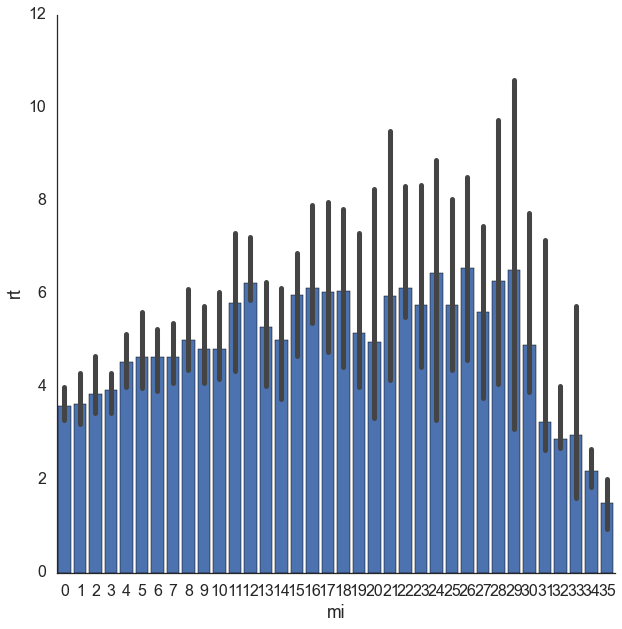

In [45]:
f, axes = plt.subplots(1,1,figsize=(10,10),squeeze=False)

sns.barplot('mi', 'rt', data=data, estimator=np.median, ax=axes[0,0], ci=95)
sns.despine()

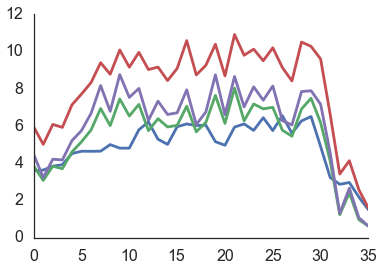

In [51]:
meds = np.array([np.median(data.loc[data.mi==i, 'rt']) for i in range(36)])
mens = np.array([np.mean(data.loc[data.mi==i, 'rt']) for i in range(36)])
sds = np.zeros(36)
sds2 = np.zeros(36)
for i in range(36):
    d = data.loc[data.mi==i, 'rt']
    sds[i] = np.mean(np.abs(d - meds[i]))
    sds2[i] = np.mean(np.abs(d-mens[i]))

plt.plot(np.arange(36), meds)
plt.plot(np.arange(36), sds)
plt.plot(np.arange(36), mens)
plt.plot(np.arange(36), sds2)
sns.despine()

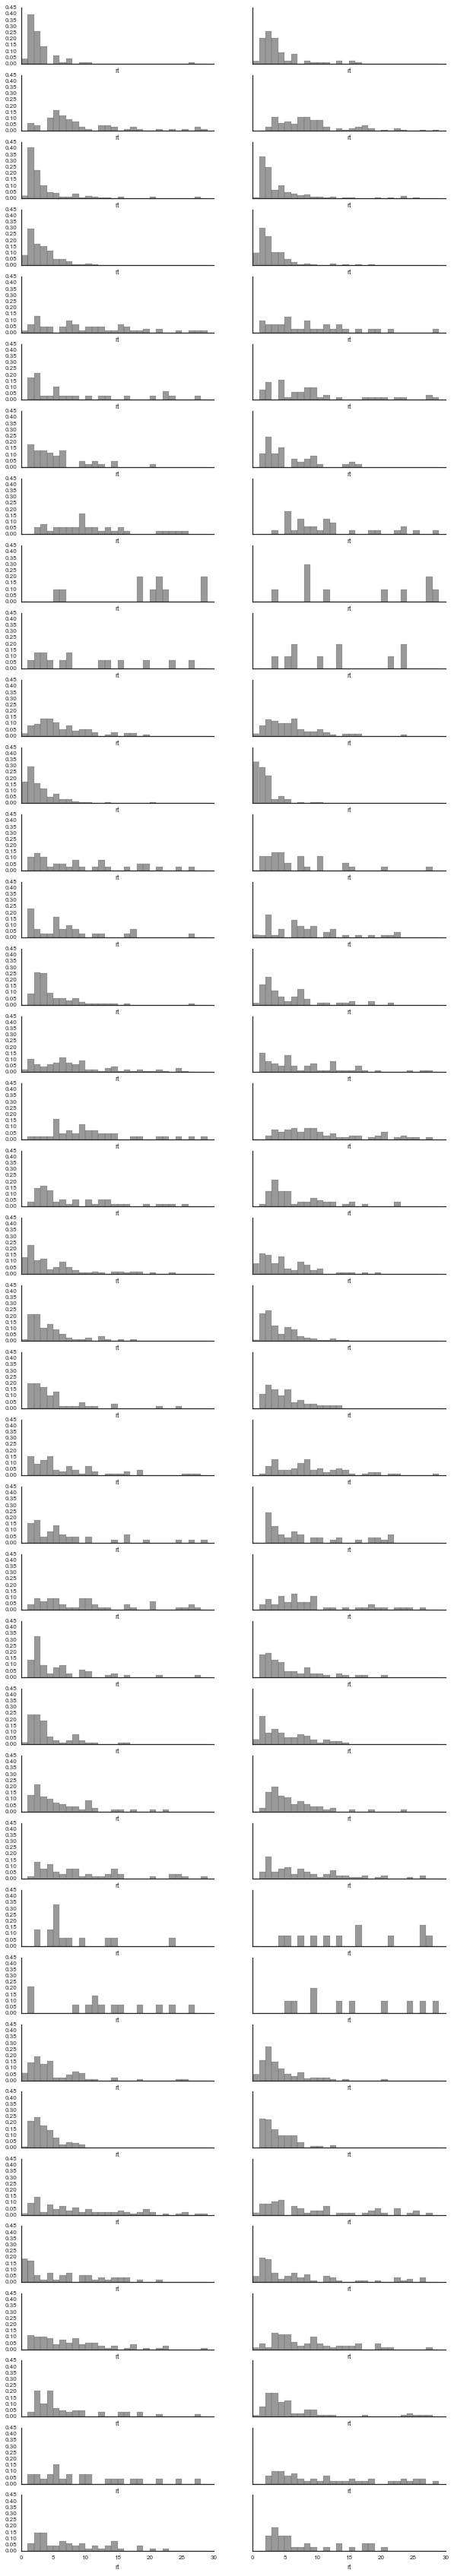

In [88]:
# f, axes = plt.subplots(nrows=38, ncols=2, figsize=(10,80), 
#                        squeeze=False, sharex=True, sharey=True)

# for i in data.subject.unique():
#     curax = axes[i, 0]
#     sns.distplot(data.loc[(data.subject==i)&(data.error==0), 'rt'], norm_hist=True, ax=curax, 
#                  color='black', kde=False, bins=list(range(30)))
#     curax = axes[i, 1]
#     sns.distplot(data.loc[(data.subject==i)&(data.error==1), 'rt'], norm_hist=True, ax=curax, 
#                  color='black', kde=False, bins=list(range(30)))
    
#     # collapse across subject, kde
#     # mean + std er for two types: rt by error or error for each subject, with error bar
    
# sns.despine()

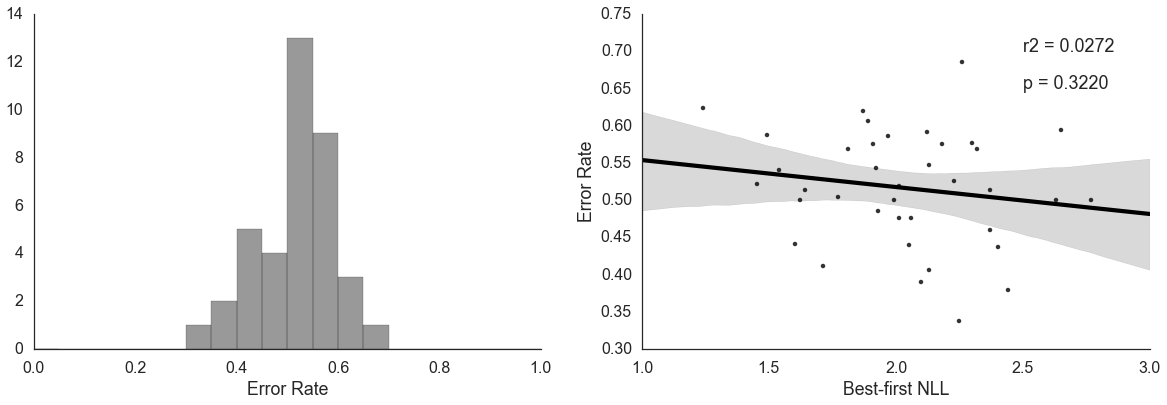

In [26]:
errs = pd.DataFrame(data=np.array([data.subject.unique(), 
                       [data.loc[data.subject == s, 'error'].sum() / len(data.loc[data.subject == s, 'error'])
                       for s in data.subject.unique()]]).T, columns=['subject', 'error_rate'])

logliks.loc[:, 'error_rate'] = errs.loc[:, 'error_rate']

f, axes = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

sns.distplot(errs.error_rate, kde=False, ax=axes[0,0],
             bins=np.linspace(0,1,21), color='black')

axes[0,0].set_xlabel('Error Rate')

sns.regplot('Best-first', 'error_rate', data=logliks, ax=axes[0,1], color='black')

x = logliks.loc[:, 'Best-first']
y = logliks.loc[:, 'error_rate']
m, b, r, p, err = sts.linregress(x,y)

axes[0, 1].text(s='r2 = ' + str(r**2)[:6], x=2.5, y=.7, size=18)
axes[0, 1].text(s='p = ' + str(p)[:6], x=2.5, y=.65, size=18)
axes[0,1].set_xlabel('Best-first NLL')
axes[0,1].set_ylabel('Error Rate')

sns.despine()
f.savefig(figure_out + 'error_rates.png', format='png')


## Movie Time

In [21]:
test

,subject,color,gi,mi,status,bp,wp,response,rt,time,inits,num_pieces,gtv,posqual,error,movietime
0,4,0,3,0,playing,000000000000000000000000000000000000,000000000000000000000000000000000000,12,2.000,1407347067145,CO,0,1.2,1.2,0,1000.0
1,5,1,3,1,playing,000000000000100000000000000000000000,000000000000000000000000000000000000,22,6.664,1407347080755,AP,1,0.0,-10000.0,1,7805.0
2,4,0,3,2,playing,000000000000100000000000000000000000,000000000000000000000010000000000000,13,4.893,1407347082153,CO,2,0.0,1.2,1,8504.0
3,5,1,3,3,playing,000000000000110000000000000000000000,000000000000000000000010000000000000,14,4.793,1407347094226,AP,3,0.0,-10000.0,1,14540.5
4,4,0,3,4,playing,000000000000110000000000000000000000,000000000000001000000010000000000000,6,2.327,1407347090560,CO,4,0.0,0.0,0,12707.5
5,5,1,3,5,playing,000000100000110000000000000000000000,000000000000001000000010000000000000,23,4.769,1407347102094,AP,5,0.0,-10000.0,1,18474.5
6,4,0,3,6,playing,000000100000110000000000000000000000,000000000000001000000011000000000000,24,19.380,1407347116025,CO,6,0.0,0.0,0,25440.0
7,5,1,3,7,playing,000000100000110000000000100000000000,000000000000001000000011000000000000,33,62.450,1407347185861,AP,7,0.0,-0.0,0,60358.0
8,4,0,3,8,playing,000000100000110000000000100000000000,000000000000001000000011000000000100,21,19.606,1407347202300,CO,8,0.0,0.0,0,68577.5
9,5,1,3,9,playing,000000100000110000000100100000000000,000000000000001000000011000000000100,32,11.526,1407347220532,AP,9,10000.0,-10000.0,1,77693.5


In [26]:
s = 4
gi = 3

test = data.loc[data.subject.isin([s, s+1]) & (data.gi == gi), :].copy().reset_index(drop=True)
test.loc[:, 'movietime'] = test.loc[:, 'time'].cumsum() - test.loc[0, 'time']
test.loc[:, 'movietime'] = test.loc[:, 'movietime'] * 1000 / test.loc[:, 'movietime'].max()
test

,subject,color,gi,mi,status,bp,wp,response,rt,time,inits,num_pieces,gtv,posqual,error,movietime
0,4,0,3,0,playing,000000000000000000000000000000000000,000000000000000000000000000000000000,12,2.000,1407347067145,CO,0,1.2,1.2,0,0.000000
1,5,1,3,1,playing,000000000000100000000000000000000000,000000000000000000000000000000000000,22,6.664,1407347080755,AP,1,0.0,-10000.0,1,62.499995
2,4,0,3,2,playing,000000000000100000000000000000000000,000000000000000000000010000000000000,13,4.893,1407347082153,CO,2,0.0,1.2,1,124.999991
3,5,1,3,3,playing,000000000000110000000000000000000000,000000000000000000000010000000000000,14,4.793,1407347094226,AP,3,0.0,-10000.0,1,187.499987
4,4,0,3,4,playing,000000000000110000000000000000000000,000000000000001000000010000000000000,6,2.327,1407347090560,CO,4,0.0,0.0,0,249.999982
5,5,1,3,5,playing,000000100000110000000000000000000000,000000000000001000000010000000000000,23,4.769,1407347102094,AP,5,0.0,-10000.0,1,312.499979
6,4,0,3,6,playing,000000100000110000000000000000000000,000000000000001000000011000000000000,24,19.380,1407347116025,CO,6,0.0,0.0,0,374.999976
7,5,1,3,7,playing,000000100000110000000000100000000000,000000000000001000000011000000000000,33,62.450,1407347185861,AP,7,0.0,-0.0,0,437.499976
8,4,0,3,8,playing,000000100000110000000000100000000000,000000000000001000000011000000000100,21,19.606,1407347202300,CO,8,0.0,0.0,0,499.999976
9,5,1,3,9,playing,000000100000110000000100100000000000,000000000000001000000011000000000100,32,11.526,1407347220532,AP,9,10000.0,-10000.0,1,562.499978


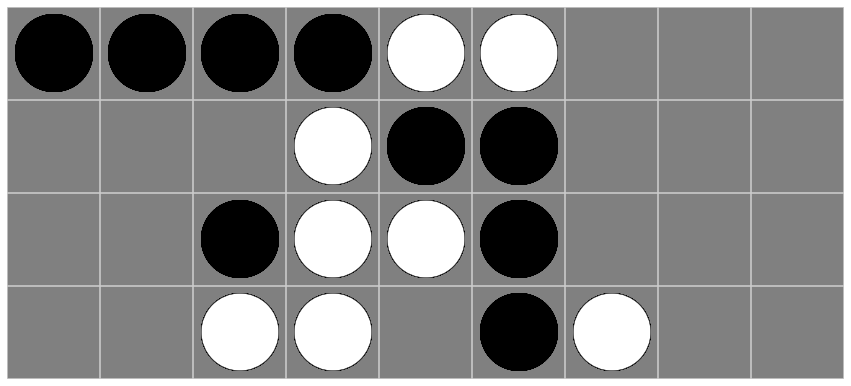

In [31]:
def shape_helper(stringrep):
    a = 35 - np.where(array_from_string_rep(stringrep)==1)[0]
    axy = np.zeros([2, a.size])
    axy[0, :] = a % 9 + .5
    axy[1, :] = a // 9 + .5
    return axy
    
def shape_position(row):
    b = shape_helper(row.bp)
    w = shape_helper(row.wp)
    return b, w

def shape_move(row):
    r = 35 - row.response
    return np.array([r % 9 + .5, r // 9 + .5]).T

def plot_position(row):
    msiz = 6000
#     b, w = shape_position(row)
#     plt.scatter(b[0], b[1], c='black', s=msiz)
#     plt.scatter(w[0], w[1], c='white', s=msiz)
    if int(row.color) == 0:
        c = 'black'
    else:
        c = 'white'
    m = shape_move(row)
    ax = plt.gca()
    ax.scatter(m[0], m[1], c=c, s=msiz)
    return ax

def movie_init():
    ax = plt.gca()
    ax.set_xlim([0,9])
    ax.set_ylim([0,4])
    ax.set_aspect(1)
    ax.grid()
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(5))
    ax.set_axis_bgcolor('grey')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    sns.despine()
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

nframes=550

def make_frames(i):
    rao = test.loc[test.movietime <= 2 * i, :]
    raow = rao.index.values[-1] if len(rao) > 1 else 0
    raow = test.loc[raow, :]
    if 2 * i > test.loc[0, 'movietime']:
        ax = plot_position(raow)
    else:
        ax = plt.gca()
    return ax

f, axes = plt.subplots(1, 1, figsize=(15, 15), squeeze=False)

movie = ani.FuncAnimation(f, make_frames, init_func=movie_init, frames=nframes, interval=100, blit=False);
movie.save(figure_out + 'test_movie3.mp4', writer='mencoder');